In [1]:
%matplotlib inline

import pandas as pd
import cosima_cookbook as cc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
import cartopy
import cartopy.crs as ccrs
import pandas as pd
import copy
import math
from collections import OrderedDict
# import seaborn as sns

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

import sys, os

os.chdir(os.path.join(os.getcwd(), "ACCESS-OM2-updated/figures/timeseries"))
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

Available exptdata keys:  ['1deg', '025deg', '01deg']


## To deal with memory issues (if needed):
* In a terminal on VDI (either over VNC or through SSH and inside screen/tmux), run:
`dask-scheduler`
* This should output the scheduler address, like `tcp://10.6.1.23:8786`. 
* Now, in another terminal (ensuring that the default conda module has cosima_cookbook installed, as all workers will need access to that), run e.g.:
`dask-worker tcp://10.6.1.23:8786 --local-directory /local/g40/aek156` (with the appropriate changes to the adderss and local directory)
* Then, make sure the following cell matches the scheduler address.

In [2]:
client=Client("tcp://10.6.46.29:8786")
client

<Client: 'tcp://10.6.46.29:8786' processes=1 threads=48, memory=188.56 GiB>

In [3]:
session = cc.database.create_session()

In [4]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [5]:
def global_scalar(variable):
    for ekey in exptdata.exptdict.keys():
        expt = exptdata.exptdict[ekey]['expt']
        time_units = exptdata.exptdict[ekey]['time_units']
        offset = exptdata.exptdict[ekey]['offset']
        darray = cc.querying.getvar(session=session, expt=expt, variable=variable)
        if offset:
            td = pd.Timedelta(days=offset)
            darray = darray.assign_coords(time=darray.time + td)
        darray = darray
        annual_average = darray.resample(time='A').mean()
        annual_average.plot(label=exptdata.exptdict[ekey]['desc'])

    plt.gca().autoscale()

In [6]:
def add_cycles():
    cycle_dates = [1778, 1838, 1898]
    ylims=plt.gca().get_ylim()
    for cd in cycle_dates:
        plt.plot([pd.Timestamp(cd,1,1),pd.Timestamp(cd,1,1)],ylims,'k--',linewidth=0.8)
    plt.gca().set_ylim(ylims)

In [7]:
temp=np.loadtxt('aravg.ann.ocean.90S.90N.v4.0.1.201901.asc')
#sst_year = temp[:,0]
#sst_year = sst_year.astype('datetime64')
#for i,year in enumerate(sst_year):
#    print(i, year)
#    sst_year[i] = pd.Timestamp(year.astype(int),7,1)
sst = temp[:,1] + 18
sst_year = pd.date_range(start='1880-07-01',freq='A',periods=sst.size)
sst_year

DatetimeIndex(['1880-12-31', '1881-12-31', '1882-12-31', '1883-12-31',
               '1884-12-31', '1885-12-31', '1886-12-31', '1887-12-31',
               '1888-12-31', '1889-12-31',
               ...
               '2010-12-31', '2011-12-31', '2012-12-31', '2013-12-31',
               '2014-12-31', '2015-12-31', '2016-12-31', '2017-12-31',
               '2018-12-31', '2019-12-31'],
              dtype='datetime64[ns]', length=140, freq='A-DEC')

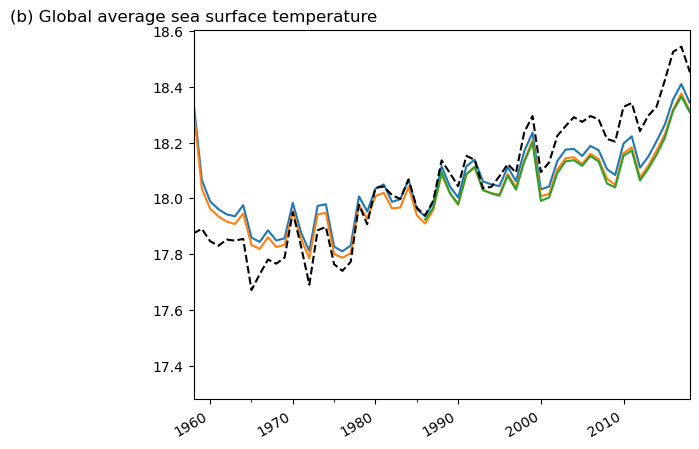

In [8]:
ax=plt.subplot(111)
global_scalar('temp_surface_ave')
plt.xlabel('')
plt.ylabel('')
ax.set_title('(b) Global average sea surface temperature',position=(0.0,1.0))
ax.set_xlim([pd.Timestamp(1958,1,1),pd.Timestamp(2017,12,31)])
ax.set_xticks([pd.Timestamp(1965,1,1), pd.Timestamp(1975,1,1), pd.Timestamp(1985,1,1)], minor=True)

ax.plot(sst_year,sst,'k--')
#plt.xlim([1958,2018])

CPU times: user 58.4 s, sys: 1.57 s, total: 59.9 s
Wall time: 27min 27s


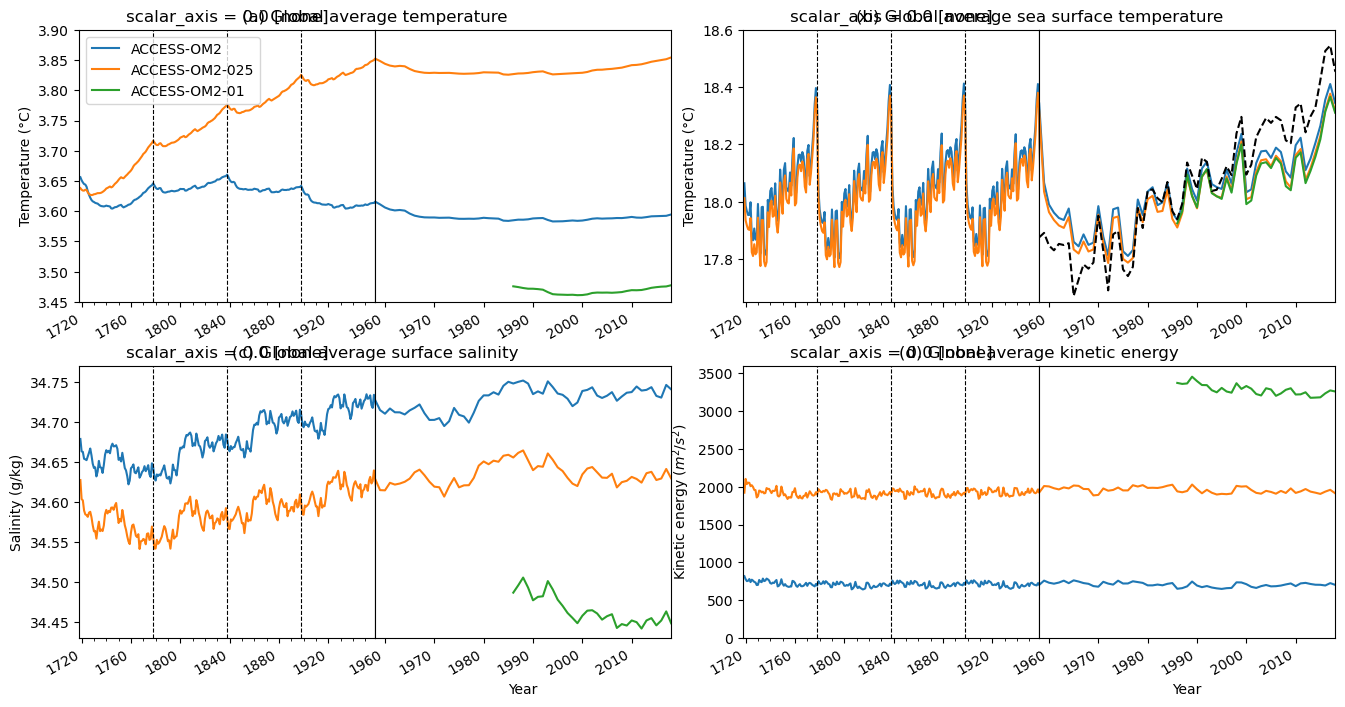

In [9]:
%%time
plt.figure(figsize=(16,8))

#############
## FIRST PLOT
ax = plt.axes([0.125, 0.545,0.185, 0.34])
global_scalar('temp_global_ave')
plt.legend()
plt.xlabel('')
plt.ylabel('Temperature (°C)')
ax.set_ylim([3.45, 3.9])
ax.set_xlim([pd.Timestamp(1718,1,1),pd.Timestamp(1957,12,31)])
ax.set_xticks([pd.Timestamp(1730,1,1), pd.Timestamp(1740,1,1), pd.Timestamp(1750,1,1), pd.Timestamp(1770,1,1), 
               pd.Timestamp(1780,1,1), pd.Timestamp(1790,1,1), pd.Timestamp(1810,1,1), pd.Timestamp(1820,1,1), 
               pd.Timestamp(1830,1,1), pd.Timestamp(1850,1,1), pd.Timestamp(1860,1,1), pd.Timestamp(1870,1,1),
               pd.Timestamp(1890,1,1), pd.Timestamp(1900,1,1), pd.Timestamp(1910,1,1), pd.Timestamp(1930,1,1),
               pd.Timestamp(1940,1,1), pd.Timestamp(1950,1,1)], minor=True)
add_cycles()

ax = plt.axes([0.31, 0.545,0.185, 0.34])
ax.set_yticks([])
global_scalar('temp_global_ave')
plt.xlabel('')
plt.ylabel('')
ax.set_title('(a) Global average temperature',position=(0.0,1.0))
ax.set_ylim([3.45, 3.9])
ax.set_xlim([pd.Timestamp(1958,1,1),pd.Timestamp(2017,12,31)])

##############
## SECOND PLOT
ax = plt.axes([0.54, 0.545,0.185, 0.34])
global_scalar('temp_surface_ave')
plt.xlabel('')
plt.ylabel('Temperature (°C)')
ax.set_ylim([17.65, 18.6])
ax.set_xlim([pd.Timestamp(1718,1,1),pd.Timestamp(1957,12,31)])
ax.set_xticks([pd.Timestamp(1730,1,1), pd.Timestamp(1740,1,1), pd.Timestamp(1750,1,1), pd.Timestamp(1770,1,1), 
               pd.Timestamp(1780,1,1), pd.Timestamp(1790,1,1), pd.Timestamp(1810,1,1), pd.Timestamp(1820,1,1), 
               pd.Timestamp(1830,1,1), pd.Timestamp(1850,1,1), pd.Timestamp(1860,1,1), pd.Timestamp(1870,1,1),
               pd.Timestamp(1890,1,1), pd.Timestamp(1900,1,1), pd.Timestamp(1910,1,1), pd.Timestamp(1930,1,1),
               pd.Timestamp(1940,1,1), pd.Timestamp(1950,1,1)], minor=True)
add_cycles()

ax = plt.axes([0.725, 0.545,0.185, 0.34])
ax.set_yticks([])
global_scalar('temp_surface_ave')
plt.xlabel('')
plt.ylabel('')
ax.set_title('(b) Global average sea surface temperature',position=(0.0,1.0))
ax.set_xlim([pd.Timestamp(1958,1,1),pd.Timestamp(2017,12,31)])
## Add Obs:
ax.plot(sst_year,sst,'k--')
ax.set_ylim([17.65, 18.6])


#############
## THIRD PLOT
ax = plt.axes([0.125, 0.125,0.185, 0.34])
global_scalar('salt_surface_ave')
plt.xlabel('')
plt.ylabel('Salinity (g/kg)')
ax.set_ylim([34.43, 34.77])
ax.set_xlim([pd.Timestamp(1718,1,1),pd.Timestamp(1957,12,31)])
ax.set_xticks([pd.Timestamp(1730,1,1), pd.Timestamp(1740,1,1), pd.Timestamp(1750,1,1), pd.Timestamp(1770,1,1), 
               pd.Timestamp(1780,1,1), pd.Timestamp(1790,1,1), pd.Timestamp(1810,1,1), pd.Timestamp(1820,1,1), 
               pd.Timestamp(1830,1,1), pd.Timestamp(1850,1,1), pd.Timestamp(1860,1,1), pd.Timestamp(1870,1,1),
               pd.Timestamp(1890,1,1), pd.Timestamp(1900,1,1), pd.Timestamp(1910,1,1), pd.Timestamp(1930,1,1),
               pd.Timestamp(1940,1,1), pd.Timestamp(1950,1,1)], minor=True)
add_cycles()

ax = plt.axes([0.31, 0.125,0.185, 0.34])
ax.set_yticks([])
global_scalar('salt_surface_ave')
plt.ylabel('')
ax.set_title('(c) Global average surface salinity',position=(0.0,1.0))
ax.set_xlabel('Year',position=(0.0,1.0))
ax.set_ylim([34.43, 34.77])
ax.set_xlim([pd.Timestamp(1958,1,1),pd.Timestamp(2017,12,31)])

#############
## FOURTH PLOT
ax = plt.axes([0.54, 0.125,0.185, 0.34])
global_scalar('ke_tot')
plt.xlabel('')
plt.ylabel('Kinetic energy ($m^2/s^2$)')
ax.set_ylim([0, 3600])
ax.set_xlim([pd.Timestamp(1718,1,1),pd.Timestamp(1957,12,31)])
ax.set_xticks([pd.Timestamp(1730,1,1), pd.Timestamp(1740,1,1), pd.Timestamp(1750,1,1), pd.Timestamp(1770,1,1), 
               pd.Timestamp(1780,1,1), pd.Timestamp(1790,1,1), pd.Timestamp(1810,1,1), pd.Timestamp(1820,1,1), 
               pd.Timestamp(1830,1,1), pd.Timestamp(1850,1,1), pd.Timestamp(1860,1,1), pd.Timestamp(1870,1,1),
               pd.Timestamp(1890,1,1), pd.Timestamp(1900,1,1), pd.Timestamp(1910,1,1), pd.Timestamp(1930,1,1),
               pd.Timestamp(1940,1,1), pd.Timestamp(1950,1,1)], minor=True)
add_cycles()

ax = plt.axes([0.725, 0.125,0.185, 0.34])
ax.set_yticks([])
global_scalar('ke_tot')
plt.ylabel('')
ax.set_title('(d) Global average kinetic energy',position=(0.0,1.0))
ax.set_xlabel('Year',position=(0.0,1.0))
ax.set_ylim([0, 3600])
ax.set_xlim([pd.Timestamp(1958,1,1),pd.Timestamp(2017,12,31)])

savefigure('GlobalTimeseries')

# plotting initial salt change due to ice adjustment 

In [10]:
exptdata.exptdict['1deg']

{'model': 'access-om2',
 'expt': '1deg_jra55v13_iaf_spinup1_B1',
 'desc': 'ACCESS-OM2',
 'n_files': -12,
 'time_units': 'days since 1718-01-01',
 'offset': -87658,
 'exptdir': '/g/data/hh5/tmp/cosima/access-om2/1deg_jra55v13_iaf_spinup1_B1'}

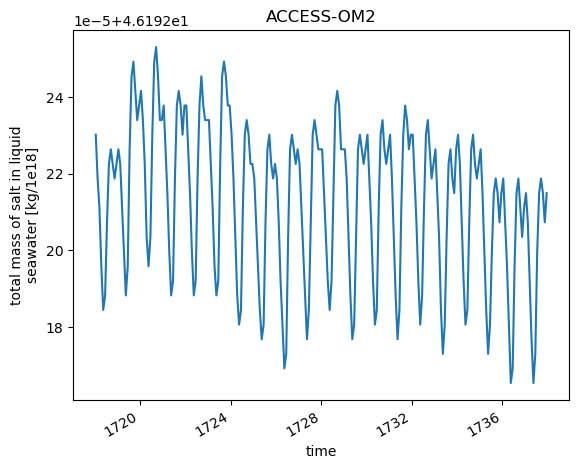

In [11]:
e = exptdata.exptdict['1deg']

offset = e['offset']
darray = cc.querying.getvar(session=session, expt=e['expt'], variable='total_ocean_salt', n=4)
if offset:
    td = pd.Timedelta(days=offset)
    darray = darray.assign_coords(time=darray.time + td)
total_ocean_salt = darray

total_ocean_salt.plot()
plt.title(e['desc'])
savefigure('total_ocean_salt_'+e['desc'])

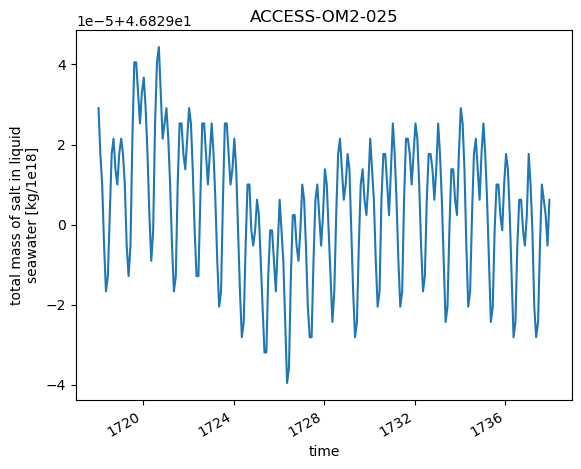

In [12]:
e = exptdata.exptdict['025deg']
offset = e['offset']
darray = cc.querying.getvar(session=session, expt=e['expt'], variable='total_ocean_salt', n=10)
if offset:
    td = pd.Timedelta(days=offset)
    darray = darray.assign_coords(time=darray.time + td)
total_ocean_salt_025 = darray

total_ocean_salt_025.plot()
plt.title(e['desc'])
savefigure('total_ocean_salt_'+e['desc'])

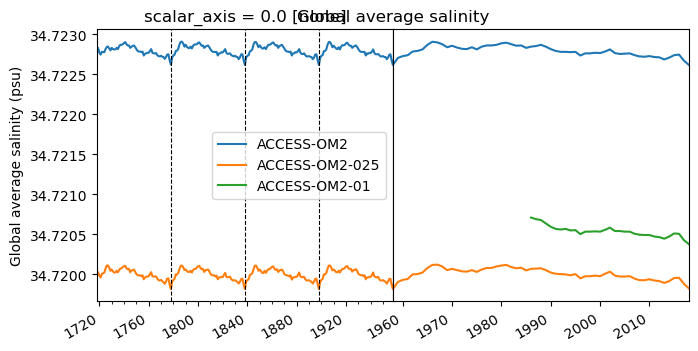

In [13]:
plt.figure(figsize=(16,8))

ax = plt.axes([0.125, 0.545,0.185, 0.34])
global_scalar('salt_global_ave')
plt.legend()
plt.xlabel('')
plt.ylabel('Global average salinity (psu)')
# ax.set_ylim([3.45, 3.9])
ax.set_xlim([pd.Timestamp(1718,1,1),pd.Timestamp(1957,12,31)])
ax.set_xticks([pd.Timestamp(1730,1,1), pd.Timestamp(1740,1,1), pd.Timestamp(1750,1,1), pd.Timestamp(1770,1,1), 
               pd.Timestamp(1780,1,1), pd.Timestamp(1790,1,1), pd.Timestamp(1810,1,1), pd.Timestamp(1820,1,1), 
               pd.Timestamp(1830,1,1), pd.Timestamp(1850,1,1), pd.Timestamp(1860,1,1), pd.Timestamp(1870,1,1),
               pd.Timestamp(1890,1,1), pd.Timestamp(1900,1,1), pd.Timestamp(1910,1,1), pd.Timestamp(1930,1,1),
               pd.Timestamp(1940,1,1), pd.Timestamp(1950,1,1)], minor=True)
add_cycles()

ax = plt.axes([0.31, 0.545,0.185, 0.34])
ax.set_yticks([])
global_scalar('salt_global_ave')
plt.xlabel('')
plt.ylabel('')
ax.set_title('Global average salinity',position=(0.0,1.0))
# ax.set_ylim([3.45, 3.9])
ax.set_xlim([pd.Timestamp(1958,1,1),pd.Timestamp(2017,12,31)])

savefigure('salt_global_ave')

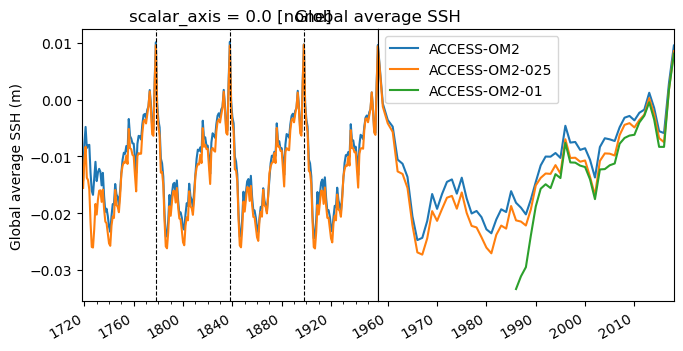

In [14]:
plt.figure(figsize=(16,8))

ax = plt.axes([0.125, 0.545,0.185, 0.34])
global_scalar('eta_global')
plt.xlabel('')
plt.ylabel('Global average SSH (m)')
# ax.set_ylim([3.45, 3.9])
ax.set_xlim([pd.Timestamp(1718,1,1),pd.Timestamp(1957,12,31)])
ax.set_xticks([pd.Timestamp(1730,1,1), pd.Timestamp(1740,1,1), pd.Timestamp(1750,1,1), pd.Timestamp(1770,1,1), 
               pd.Timestamp(1780,1,1), pd.Timestamp(1790,1,1), pd.Timestamp(1810,1,1), pd.Timestamp(1820,1,1), 
               pd.Timestamp(1830,1,1), pd.Timestamp(1850,1,1), pd.Timestamp(1860,1,1), pd.Timestamp(1870,1,1),
               pd.Timestamp(1890,1,1), pd.Timestamp(1900,1,1), pd.Timestamp(1910,1,1), pd.Timestamp(1930,1,1),
               pd.Timestamp(1940,1,1), pd.Timestamp(1950,1,1)], minor=True)
add_cycles()

ax = plt.axes([0.31, 0.545,0.185, 0.34])
ax.set_yticks([])
global_scalar('eta_global')
plt.legend()
plt.xlabel('')
plt.ylabel('')
ax.set_title('Global average SSH',position=(0.0,1.0))
# ax.set_ylim([3.45, 3.9])
ax.set_xlim([pd.Timestamp(1958,1,1),pd.Timestamp(2017,12,31)])
savefigure('eta_global')